# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

После первичного знакомства с данными видим что у нас 23699 строк, которые содержат информацию об объявлениях по продаже недвижимости в СПБ и его области. 

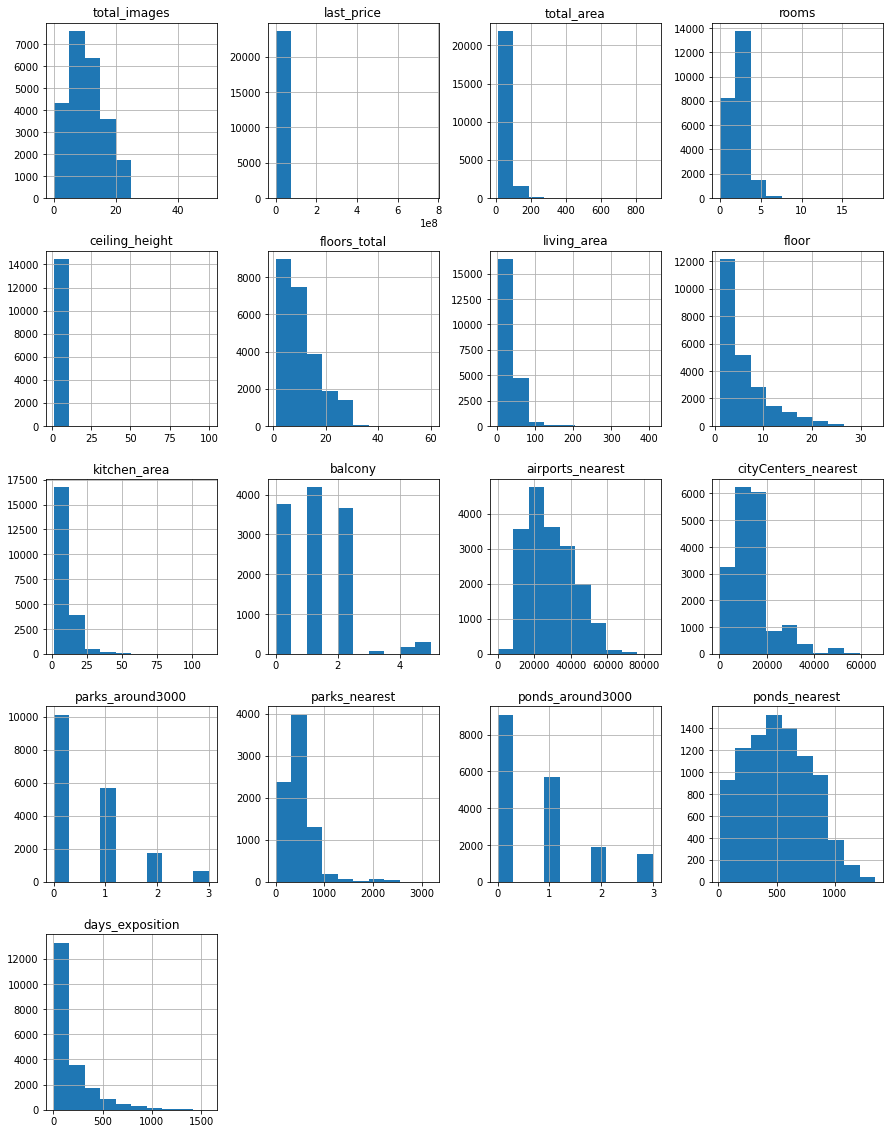

In [3]:
data.select_dtypes(include='number').hist(figsize=(15, 20))
plt.show()

In [4]:
display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


После отрисовки графиков и вывода первых 5-и строчек датафрейма заметно, что все столбцы названы корректно.
Полностью заполнены следующие столбцы:  total_images, last_price, total_area, first_day_exposition, rooms.
Некоторые второстепенные признаки содержат значительное кол-во пропусков и требуют заполнения либо обработки (is_apartment, balcony, ceiling_height, parks_nearest)

### Выполним предобработку данных

In [5]:

missing_vals = data.isna().sum()
missing_vals = missing_vals[missing_vals > 0]
# print(missing_vals)
# missing values in columns 'balcony', 'total_images', 'parks_around3000' and 'ponds_around3000' can be changed to 0
data[['balcony', 'total_images', 'parks_around3000', 'ponds_around3000']] = data[['balcony', 'total_images', 'parks_around3000', 'ponds_around3000']].fillna(0)
display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


В столбцах 'balcony', 'total_images', 'parks_around3000', 'ponds_around3000' пропущенные ячейки появляются скорее всего из-за того, что их значения равны нулю, и во время заполнения объявления о продаже просто были попущенны, в силу чего можно смело заменять их на 0. В остальных же столбцах значения могут быть пропущенны из-за ошибки в формате или из-за ошибок при подготовке данных (попытки ручной очистке или фильтрации) или просто потому что при составлении объявления были не заполненны некоторые параметры, получить точную информацию о них не получится, так что их не трогаем.

In [6]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment             object
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

In [7]:
# detect float columns where all values are whole numbers, which could be changed to integer types
for col in data.select_dtypes(include='float'):
    if data[col].dropna().apply(float.is_integer).all():
        data[col] = data[col].astype('Int64')

# convert column 'first_day_exposition' from object to datetime
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], errors='coerce')

# convert 'locality_name' to category type
data['locality_name'] = data['locality_name'].astype('str')
data.dtypes

total_images                     int64
last_price                       Int64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     Int64
living_area                    float64
floor                            int64
is_apartment                    object
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          Int64
locality_name                   object
airports_nearest                 Int64
cityCenters_nearest              Int64
parks_around3000                 Int64
parks_nearest                    Int64
ponds_around3000                 Int64
ponds_nearest                    Int64
days_exposition                float64
dtype: object

Находим столбцы в которых каждое значение является целым числом и переводим их из типа float в тип int.

Далее переводим все значения столбца 'first_day_exposition' в тип datetime для того чтобы в дальнейшем можно было производить временные операции (разница дат, сортировка и т.п.)

И наконец переводим столбец 'locality_name' в str для дальнейшей обработки дубликатов.

In [8]:
data['locality_name'].nunique()

365

В столбце locality_name 365 уникальных значения, ниже избавимся от неявных дубликатов, удалим из названий 'поселок', 'деревня', 'село' и подобные.

In [9]:
import re

def normalize(loc):
    if isinstance(loc, str):
        loc = loc.lower()
        loc = loc.replace('ё', 'е')
        loc = re.sub(r'\b(поселок городского типа|поселок|деревня|пгт|д\.?|село|садовое товарищество|городской поселок)\b', '', loc)
        loc = re.sub(r'[^а-я0-9-]', '', loc)
        return loc.title()
    return loc

data['locality_name'] = data['locality_name'].apply(normalize)
print(data['locality_name'].sort_values().unique())
data['locality_name'].nunique()

['' 'Агалатово' 'Александровская' 'Алексеевка' 'Аннино' 'Аро' 'Барышево'
 'Батово' 'Бегуницы' 'Белогорка' 'Белоостров' 'Бокситогорск'
 'Большаявруда' 'Большаяижора' 'Большаяпустомержа' 'Большиеколпаны'
 'Большоерейзино' 'Большойсабск' 'Бор' 'Борисовагрива' 'Бугры' 'Будогощь'
 'Ваганово' 'Важины' 'Вартемяги' 'Вахновакара' 'Виллози' 'Вознесенье'
 'Возрождение' 'Войсковицы' 'Войскорово' 'Володарское' 'Волосово' 'Волхов'
 'Всеволожск' 'Выборг' 'Вырица' 'Выскатка' 'Высокоключевой' 'Высоцк'
 'Гаврилово' 'Гарболово' 'Гатчина' 'Гладкое' 'Глажево' 'Глебычево'
 'Глинка' 'Гончарово' 'Горбунки' 'Гостилицы' 'Громово' 'Дзержинского'
 'Дружнаягорка' 'Дружноселье' 'Дубровка' 'Елизаветино' 'Ефимовский'
 'Жилгородок' 'Жилпоселок' 'Житково' 'Заводской' 'Заклинье' 'Заневка'
 'Запорожское' 'Зеленогорск' 'Зимитицы' 'Ивангород' 'Извара' 'Ильичево'
 'Имениморозова' 'Именисвердлова' 'Иссад' 'Калитино' 'Каложицы' 'Кальтино'
 'Каменногорск' 'Камышовка' 'Каськово' 'Келози' 'Кикерино' 'Кингисепп'
 'Кингисеппский' 

310

Удалось избавиться от 55 неявных дубликатов

В ходе предобработки данных выполнили следующее:
- нашли все пропущенные значения, и заполнили пропуски в столбцах 'balcony', 'total_images', 'parks_around3000', 'ponds_around3000'
- заменили тип данных с float на int в столбцах, где каждое значение является целым числом
- заменили тип данных в столбце 'first_day_exposition' на тип datetime для работы с датами
- в столбце 'locality_name' заменили тип данных на str для обработки дубликатов
- нашли неявные дубликаты в столбце 'locality_name' и избавились от 55 путем удаления из названия таких слов, как: поселок городского типа, поселок, деревня, пгт, д., село, садовое товарищество, городской поселок

### Добавим в таблицу новые столбцы

In [10]:
data['price_per_sq_meter'] = (data['last_price'] / data['total_area']).apply(lambda x: round(x, 2) if pd.notna(x) else np.nan)

data['exposition_weekday'] = data['first_day_exposition'].dt.weekday

data['exposition_month'] = data['first_day_exposition'].dt.month

data['exposition_year'] = data['first_day_exposition'].dt.year

def floor_type(row):
    if pd.isna(row['floor']) or pd.isna(row['floors_total']):
        return np.nan
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
    
data['floor_type'] = data.apply(floor_type, axis=1)

data['city_center_km'] = (data['cityCenters_nearest'] / 1000).apply(lambda x: round(x) if pd.notna(x) else pd.NA).astype('Int64')

display(data[['price_per_sq_meter', 'exposition_weekday', 'exposition_month', 'exposition_year', 'floor_type', 'city_center_km']])

,price_per_sq_meter,exposition_weekday,exposition_month,exposition_year,floor_type,city_center_km
0,120370.37,3,3,2019,другой,16
1,82920.79,1,12,2018,первый,19
2,92785.71,3,8,2015,другой,14
3,408176.10,4,7,2015,другой,7
4,100000.00,1,6,2018,другой,8
...,...,...,...,...,...,...
23694,72490.85,1,3,2017,другой,4
23695,52542.37,0,1,2018,другой,<NA>
23696,44091.71,6,2,2018,первый,<NA>
23697,149511.40,1,3,2017,другой,10


В таблицу были добавлены следующие новые столбцы: 'price_per_sq_meter' - цена за квадратный метр; 'exposition_weekday' - день недели, в который было выставленно объявление; 'exposition_month' - месяц, в который было выставленно объявление; 'exposition_year' - год, в который было выставленно объявление; 'floor_type' - тип этажа (первый, последний или другой); 'city_center_km' - расстояние до центра города в км

### Проведем исследовательский анализ данных

Создадим функцию для отрисовки гистограммы с отсечением выбросов, обработаем столбец 'ceiling_height' и построим гистограммы

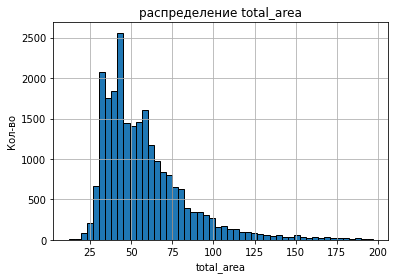

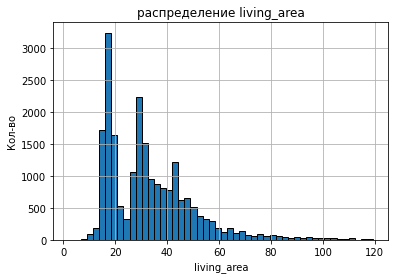

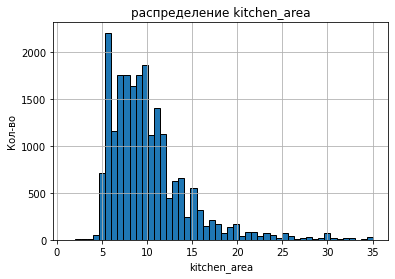

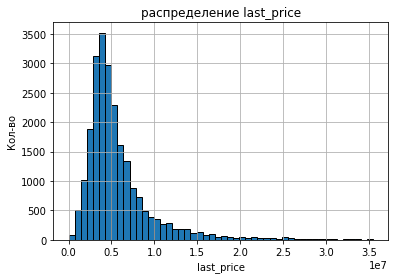

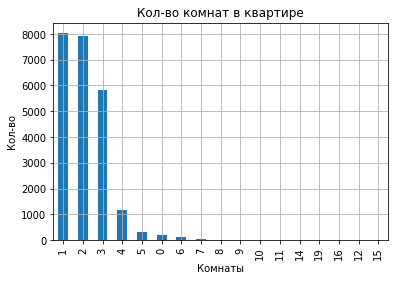

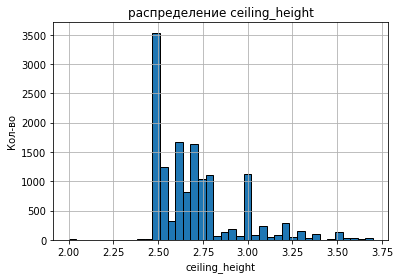

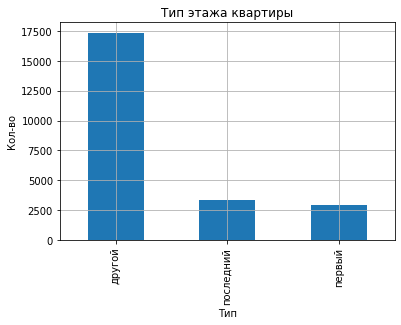

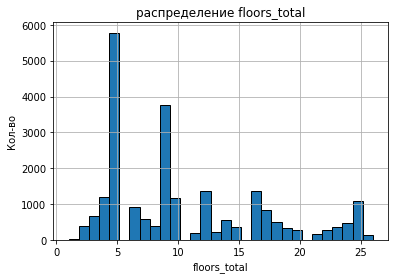

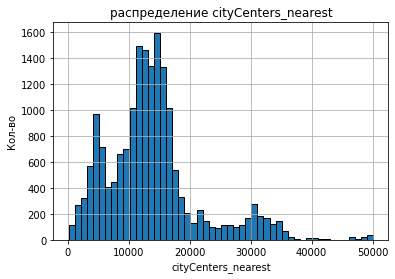

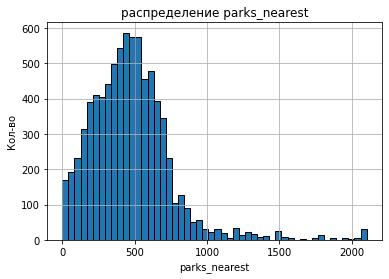

In [11]:
def plot_hist(column, bins=50, quantile=0.99):
    clean_series = data[column].dropna()
    threshold = clean_series.quantile(quantile)
    plt.hist(clean_series[clean_series <= threshold], bins=bins, edgecolor='black')
    plt.title(f'распределение {column}')
    plt.xlabel(column)
    plt.ylabel('Кол-во')
    plt.grid(True)
    plt.show()
    
data['ceiling_height'] = data['ceiling_height'].replace({25: 2.5, 32: 3.2})

data = data[(data['ceiling_height'].isna()) | ((data['ceiling_height'] >= 2) & (data['ceiling_height'] <= 5))]

plot_hist('total_area')
plot_hist('living_area')
plot_hist('kitchen_area')
plot_hist('last_price')

data['rooms'].value_counts().plot(kind='bar')
plt.title('Кол-во комнат в квартире')
plt.xlabel('Комнаты')
plt.ylabel('Кол-во')
plt.grid(True)
plt.show()

plot_hist('ceiling_height', bins=40)

data['floor_type'].value_counts().plot(kind='bar')
plt.title('Тип этажа квартиры')
plt.xlabel('Тип')
plt.ylabel('Кол-во')
plt.grid(True)
plt.show()

plot_hist('floors_total', bins=30)
plot_hist('cityCenters_nearest')
plot_hist('parks_nearest')



**Наблюдения по параметрам объектов:**
Общая, жилая и кухонная площадь - основная масса значений находится в диапазоне до 100 квадратных метров.
- Цена - подавляющее большинство объектов стоят до 20 млн рублей.
- Кол-во комнат - основная масса - 1-3 комнатные квартиры, редкие случаи от 5 и выше
- Высота потолков - большая часть квартир имеет потолки от 2.5 до 3 метров. Ошибочные значения 25 и 32 были заменены на 2.5 и 3.2 соответственно
- Тип этажа - большинство квартир находятся не на первом и не на последнем этажах.
- Кол-во этажей в доме - чаще остальых встречаются 5, 9-и этажные дома, уже крайне редко встречаются дома больше 25 этажей.
- Расстояние до центра ближайшего города - в основном до 20 км.
- Расстояние до ближайшего парка - чаще всего в пределах от 0 до 1 км.

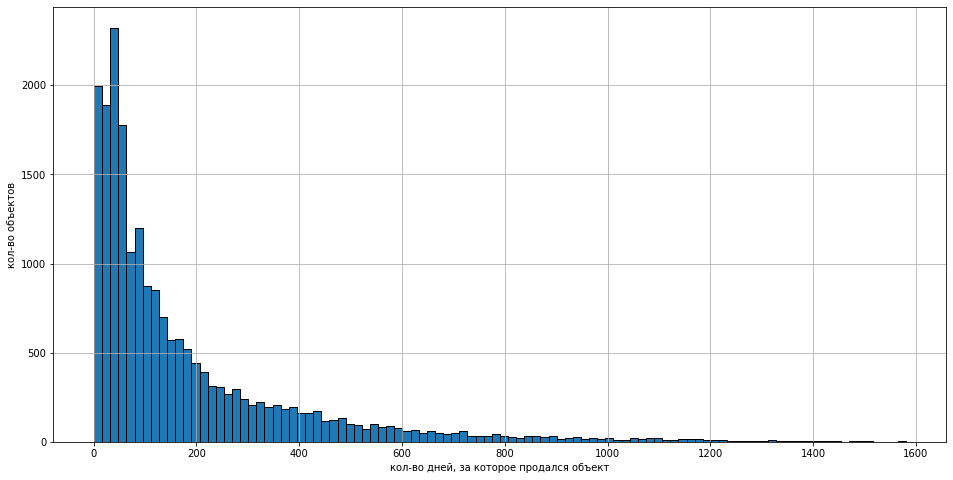

Среднее время экспозиции 180.87126683583838
Медиана времени экспозиции 95.0
25-й квартиль: 45.00000000000001
75-й квартиль: 232.0


In [12]:
data['days_exposition'].hist(bins=100, figsize=(16, 8), edgecolor='black')
plt.xlabel('кол-во дней, за которое продался объект')
plt.ylabel('кол-во объектов')
plt.grid(True)
plt.show()


print('Среднее время экспозиции', data['days_exposition'].mean())
print('Медиана времени экспозиции', data['days_exposition'].median())

q1 = data['days_exposition'].quantile(0.25)
q3 = data['days_exposition'].quantile(0.75)

print(f'25-й квартиль: {q1}')
print(f'75-й квартиль: {q3}')

среднее время продажи около 180 дней, медианное же значение - 95 дней

быстрыми можно считать продажи до 45 дней, а необычно долгими от 232 дней

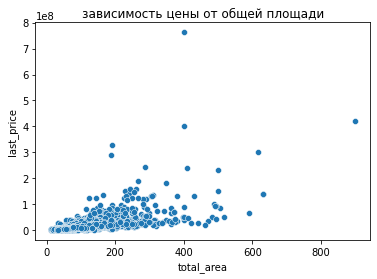

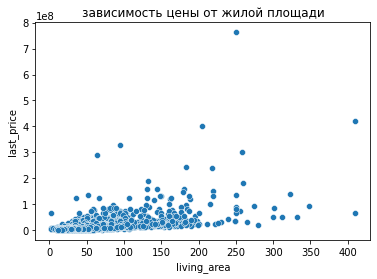

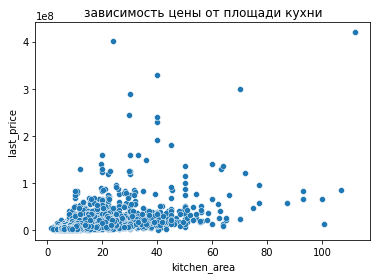

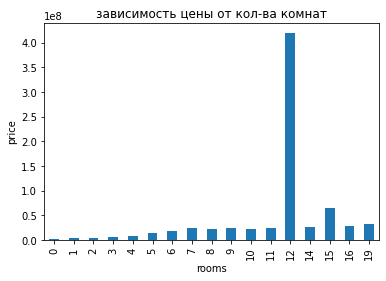

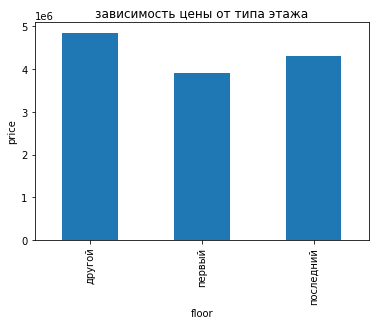

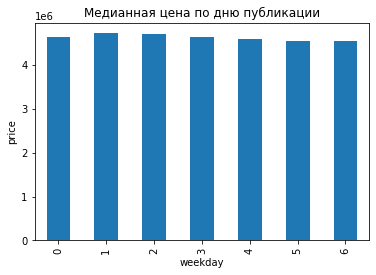

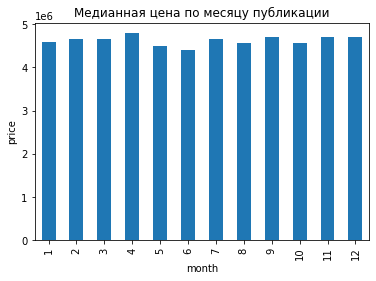

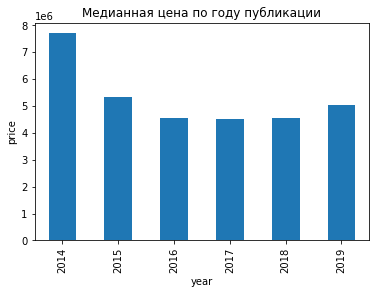

In [13]:


sns.scatterplot(x='total_area', y='last_price', data=data)
plt.title('зависимость цены от общей площади')
plt.show()

sns.scatterplot(x='living_area', y='last_price', data=data)
plt.title('зависимость цены от жилой площади')
plt.show()

sns.scatterplot(x='kitchen_area', y='last_price', data=data)
plt.title('зависимость цены от площади кухни')
plt.show()

data.groupby('rooms')['last_price'].median().plot(kind='bar')
plt.title('зависимость цены от кол-ва комнат')
plt.ylabel('price')
plt.xlabel('rooms')
plt.show()

data.groupby('floor_type')['last_price'].median().plot(kind='bar')
plt.title('зависимость цены от типа этажа')
plt.ylabel('price')
plt.xlabel('floor')
plt.show()

data.groupby('exposition_weekday')['last_price'].median().plot(kind='bar')
plt.title('Медианная цена по дню публикации')
plt.ylabel('price')
plt.xlabel('weekday')
plt.show()

data.groupby('exposition_month')['last_price'].median().plot(kind='bar')
plt.title('Медианная цена по месяцу публикации')
plt.ylabel('price')
plt.xlabel('month')
plt.show()

data.groupby('exposition_year')['last_price'].median().plot(kind='bar')
plt.title('Медианная цена по году публикации')
plt.ylabel('price')
plt.xlabel('year')
plt.show()

- Явная зависимость видна между общей и жилой и площадью и ценой (больше площадь - выше цена), тоже самое с площадью кухни, но цена растет меньше;
- Тоже самое можно сказать и о количестве комнат;
- По графикам видно, что квартиры на первом этаже часто дешевле чем на других;
- Цена не зависит напрямую от дня или месяца публикации, но с 2014 по 2016 видно значительное падение цен и дальнейшая стабилизация.

In [15]:
top_localities = (data
                 .groupby('locality_name')
                 .agg(count=('locality_name', 'count'),
                     mean_price_bar_m2=('price_per_sq_meter', 'mean'))
                 .sort_values('count', ascending=False)
                 .head(10))

display(top_localities)

,count,mean_price_bar_m2
locality_name,,
Санкт-Петербург,15699,114750.688686
Мурино,588,86064.821173
Кудрово,472,95324.930508
Шушары,440,78677.364318
Всеволожск,398,68654.473970
Пушкин,369,103125.819377
Колпино,338,75424.579112
Парголово,327,90175.913089
Гатчина,307,68746.146515


В 10 населенных пунктов с наибольшим числом объявлений вошли: Санкт-Петербург, Мурино, Кудрово, Шушары, Всеволожск, Пушкин, Колпино, Парголово, Гатчина и Выборг.
Самый дорогой квадратный метр в СПБ - 114750, а самый дешевый в Выборге - 58141

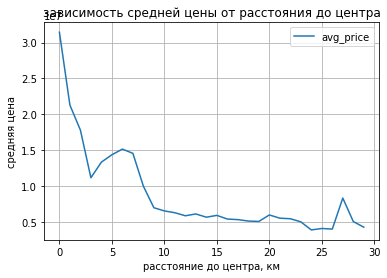

In [16]:
spb_flats = data[data['locality_name'] == 'Санкт-Петербург'].copy()

price_by_distance = (spb_flats
                    .dropna(subset=['city_center_km'])
                    .groupby('city_center_km')
                    .agg(avg_price=('last_price', 'mean')))

price_by_distance.plot()
plt.title('зависимость средней цены от расстояния до центра')
plt.xlabel('расстояние до центра, км')
plt.ylabel('средняя цена')
plt.grid(True)
plt.show()

Построив график зависимости средней цены от расстояния до центра СПБ можно сделать следующие выводы:
Цена выше всего в радиусе 10 км от центра СПБ.
Еще один скачок цены виден на расстоянии между 25 и 30 км от центра, что можно объяснить нахождением на этом расстоянии на этом расстоянии КАД или элитных жилых районов.

## Итоговый вывод по анализу рынка недвижимости Санкт-Петербурга и Ленинградской области

## Обработка и преобразование данных

Перед проведением анализа были выполнены следующие шаги подготовки данных:

- Заменены пропущенные значения в ключевых признаках ('balcony', 'total_images', 'parks_around3000', 'ponds_around3000').
- Преобразованы типы данных: даты переведены в формат datetime, целые числа с плавающей точкой на Int
- Произведена обработка неявных дубликатов, удалено 55 штук.
- Добавлены новые столбцы:
  - price_per_sq_meter — цена за квадратный метр;
  - floor_type — категория этажа (первый, последний, другой);
  - city_center_km — расстояние до центра Санкт-Петербурга;
  - exposition_weekday, exposition_month, exposition_year — день недели, месяц и год размещения объявления;


## Основные факторы, влияющие на цену квартиры

По результатам исследования выявлены следующие ключевые факторы, влияющие на цену недвижимости:

- Общая площадь — один из самых значимых факторов, цена растёт с увеличением площади;
- Количество комнат — стабильный рост цены с увеличением кол-ва комнат;
- Тип этажа — квартиры на первом этаже дешевле, чем на остальных;
- С 2014-го по 2016 цена на квартиры резко падала, после чего стабилизировалась.\



## Где больше всего объявлений и где жильё дороже?

### 10 населённых пунктов по числу объявлений:

Санкт-Петербург, Мурино, Кудрово, Шушары, Всеволожск, Пушкин, Колпино, Парголово, Гатчина и Выборг

Самым дорогим оказался квадратный метр в СПБ, а самым дешевым в Выборге




## Зависимость цены от расстояния до центра Санкт-Петербурга

- Цена за квадратный метр снижается с удалённостью от центра.
- В радиусе до 5 км — максимальные цены.
- 5-10 км — устойчивое снижение, которое стабилизируется после 10 км.
- 25-30 - цены резко увеличиваются, что может быть связано с нахождением на этом расстоянии КАД или элитных жилых районов.

## Среднестатистическая квартира из объявления на основе результатов анализа
- кол-во комнат: 2
- цена: 10000000
- квадратов: 45
- расстояние до центра: 10-15 км
- этажей в доме: 5
- ближайший парк в 0.5 км
- высота потолка 2.5 м
- на любом этаже кроме первого и последнего




## Общий итог

Стоимость квартиры на вторичном рынке Санкт-Петербурга и Ленинградской области в наибольшей степени зависит от площади, удалённости от центра, и количества комнат.  
Географически самые дорогие объекты расположены в Санкт-Петербурге. Эти зависимости полезны для прогнозирования рыночной стоимости и определения ценовой стратегии.